# DATA UNDERSTANDING, CLEANING, AND PROCESSING

In [67]:
# Library Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [68]:
# import data
df = pd.read_csv("sickness_table.csv")
df.head()

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


Column Description:

• date: entry date

• n_sick: number of drivers called sick on duty

• calls: number of emergency calls

• n_duty: number of drivers on duty available

• n_sby: number of standby resources available

• sby_need: number of standbys, which are activated on a given day

• dafted: number of additional drivers needed due to not enough standbys

In [70]:
# change column names to improve readability
df.rename(
    columns={"date": "Date", 
             "n_sick": "drivers on duty that called in sick", 
             "calls": "emergency calls", 
             "n_duty": "drivers on duty available", 
             "n_sby": "standby resources available",
             "sby_need": "standby drivers activated",
             "dafted": "additional drivers needed due to not enough standbys"},
    inplace=True,
)

The project aims at minimizing dates with not enough standby drivers while having only standbys that will be used. Thus, the target variable for our model shall be number_of_standbys_activated

In [71]:
df.head()

,Unnamed: 0,Date,drivers on duty that called in sick,emergency calls,drivers on duty available,standby resources available,standby drivers activated,additional drivers needed due to not enough standbys
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,4,2016-04-05,63,7236.0,1700,90,0.0,0.0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            1152 non-null   int64  
 1   Date                                                  1152 non-null   object 
 2   drivers on duty that called in sick                   1152 non-null   int64  
 3   emergency calls                                       1152 non-null   float64
 4   drivers on duty available                             1152 non-null   int64  
 5   standby resources available                           1152 non-null   int64  
 6   standby drivers activated                             1152 non-null   float64
 7   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


In [73]:
# drop Unnamed column
df.drop(df.filter(regex="Unnamed"),axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 7 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Date                                                  1152 non-null   object 
 1   drivers on duty that called in sick                   1152 non-null   int64  
 2   emergency calls                                       1152 non-null   float64
 3   drivers on duty available                             1152 non-null   int64  
 4   standby resources available                           1152 non-null   int64  
 5   standby drivers activated                             1152 non-null   float64
 6   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 63.1+ KB


There are no null values in the data.

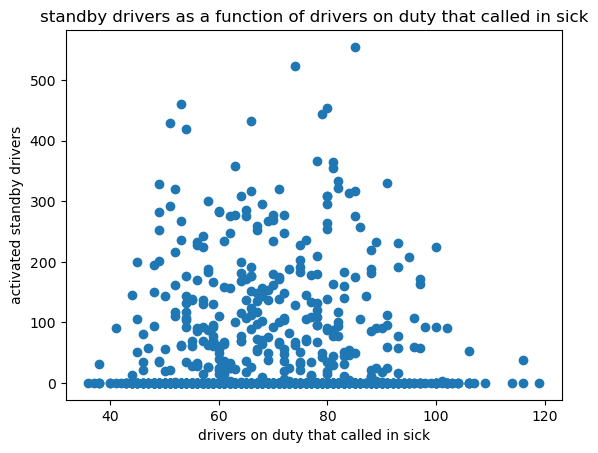

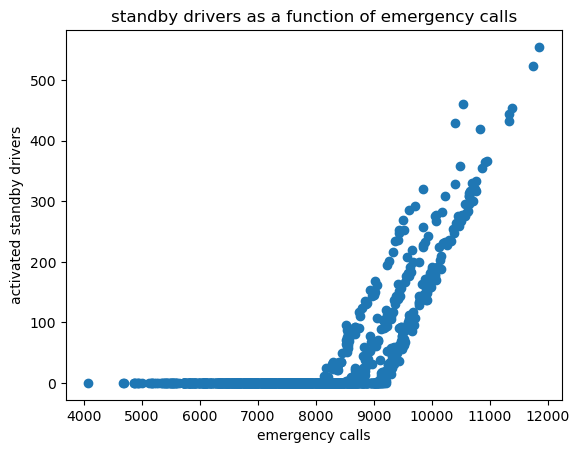

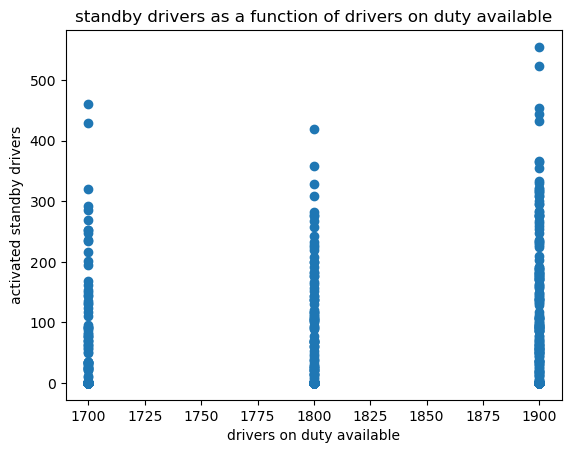

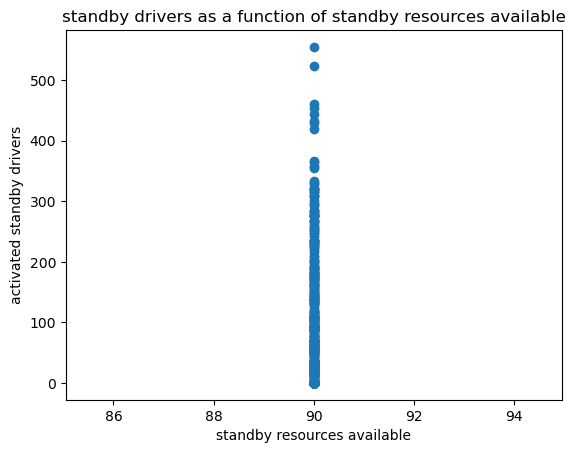

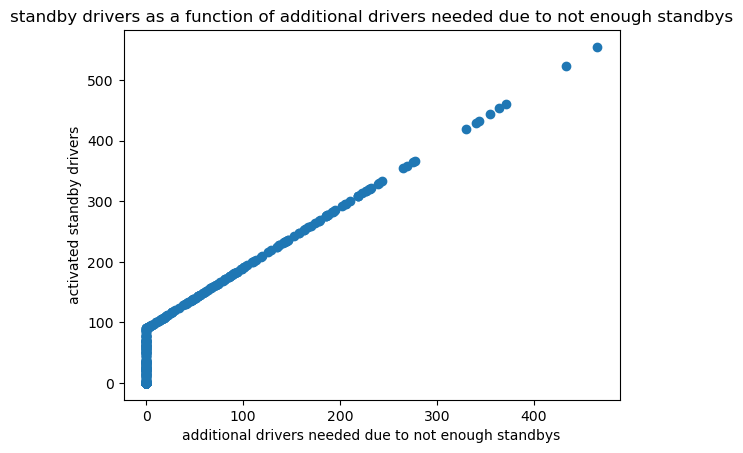

In [74]:
# Select numerical columns
df_numerical_columns = df.drop(columns=['Date','standby drivers activated'])

# Relationship between the target variables and the numerical variables

for label in df_numerical_columns.columns:
  plt.scatter(df_numerical_columns[label], df["standby drivers activated"])
  plt.title(f'standby drivers as a function of {label}')
  plt.ylabel("activated standby drivers")
  plt.xlabel(label)
  plt.show()

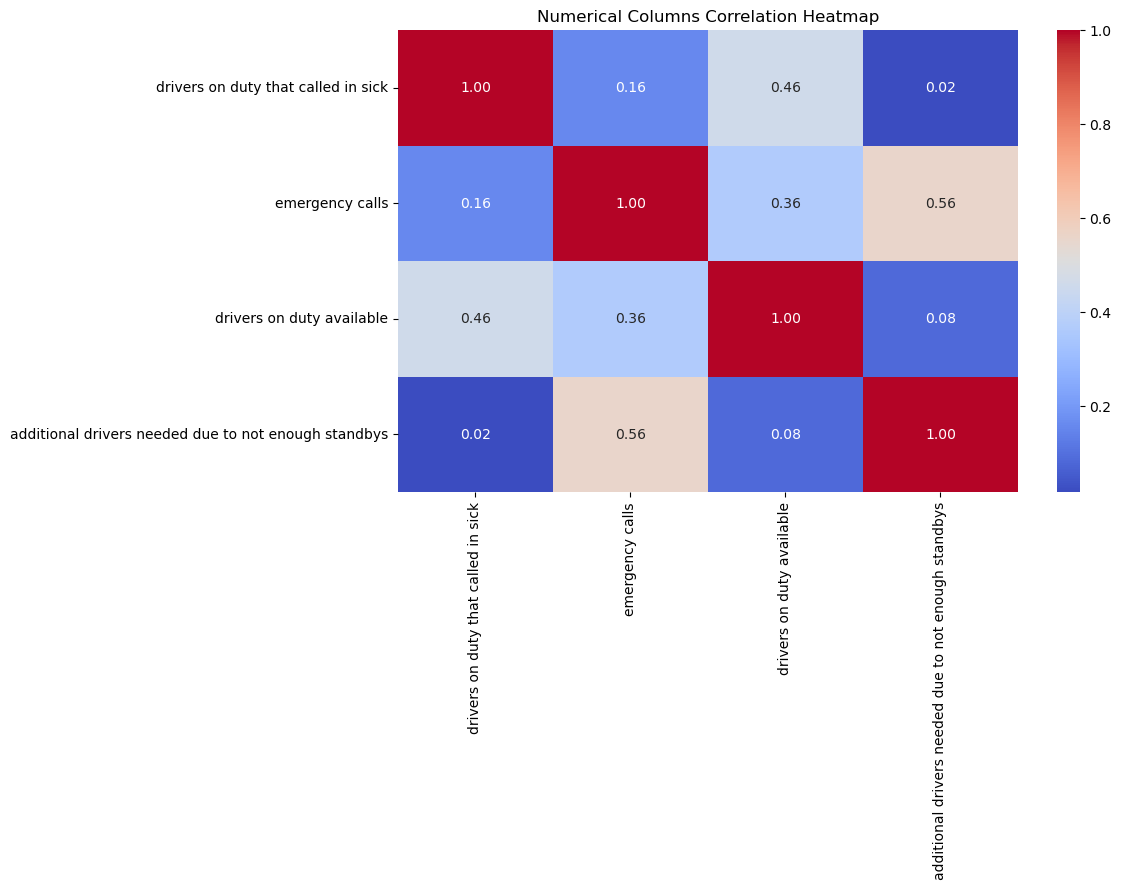

In [75]:
# Calculate correlation matrix
correlation_matrix = df_numerical_columns.drop(columns=['standby resources available']).corr()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Columns Correlation Heatmap')
plt.show()

There is a moderate correlation between the number of emergency calls and the number of additional drivers needed due to not enough standby drivers. This correlation is expected because the higher the volume of calls, the higher the number of drivers needed and the higher the number of additional drivers needed.

In [76]:
# Convert 'Date' from string to date
df['Date'] = pd.to_datetime(df['Date'])

In [77]:
# set date as index
df.index = pd.to_datetime(df['Date'])
df.drop(df.filter(regex="Date"),axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 6 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   drivers on duty that called in sick                   1152 non-null   int64  
 1   emergency calls                                       1152 non-null   float64
 2   drivers on duty available                             1152 non-null   int64  
 3   standby resources available                           1152 non-null   int64  
 4   standby drivers activated                             1152 non-null   float64
 5   additional drivers needed due to not enough standbys  1152 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 63.0 KB


Text(0, 0.5, 'Count')

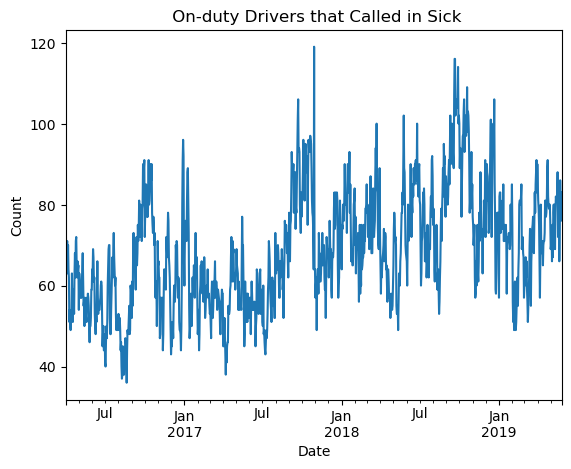

In [78]:
# Plot 'on-drivers that called in sick' over time
df['drivers on duty that called in sick'].plot()
plt.title(' On-duty Drivers that Called in Sick')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

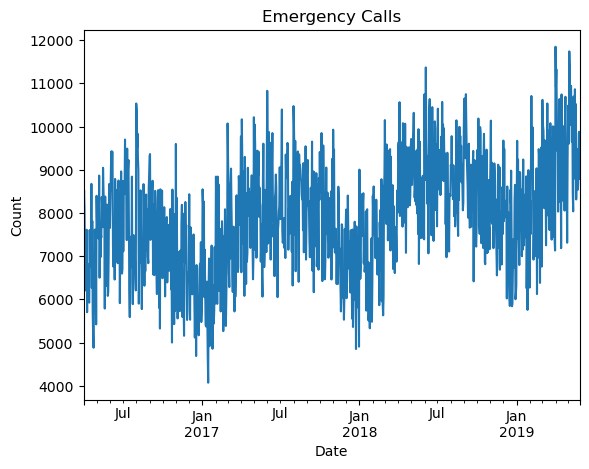

In [79]:
# Plot 'emergency calls' over time
df['emergency calls'].plot()
plt.title('Emergency Calls')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

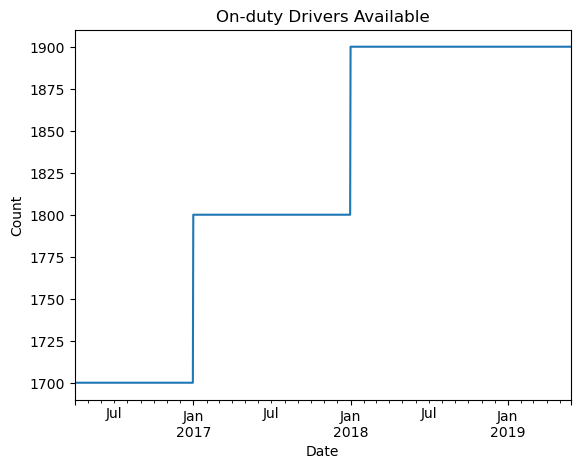

In [80]:
# Plot 'on-drivers available' over time
df['drivers on duty available'].plot()
plt.title('On-duty Drivers Available')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

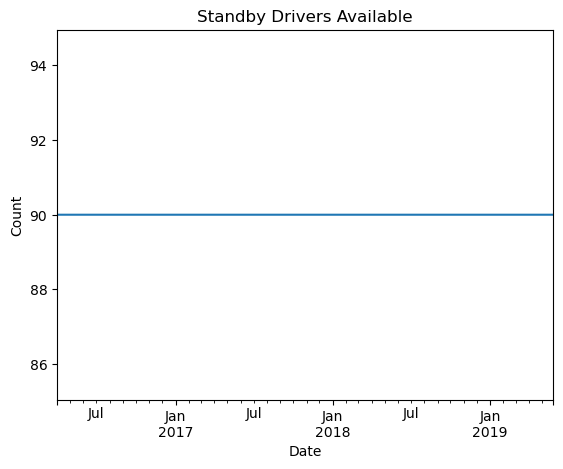

In [81]:
# Plot 'standby drivers available' over time
df['standby resources available'].plot()
plt.title('Standby Drivers Available')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

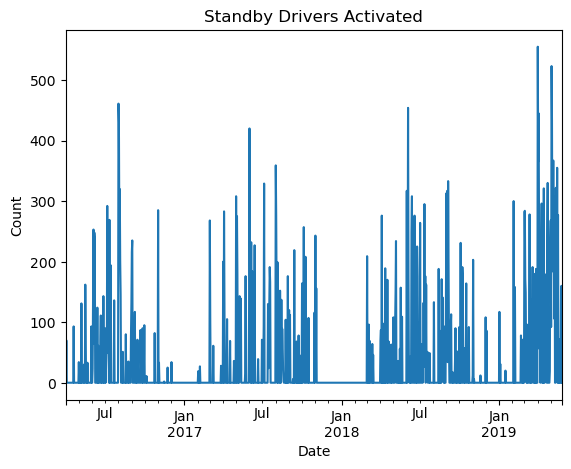

In [82]:
# Plot 'standbys activated' over time
df['standby drivers activated'].plot()
plt.title('Standby Drivers Activated')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

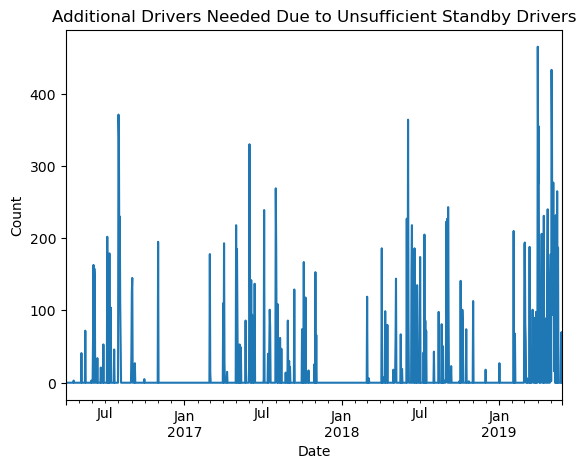

In [83]:
# Plot 'additional drivers needed due to not enough standbys' over time
df['additional drivers needed due to not enough standbys'].plot()
plt.title('Additional Drivers Needed Due to Unsufficient Standby Drivers')
plt.ylabel('Count')

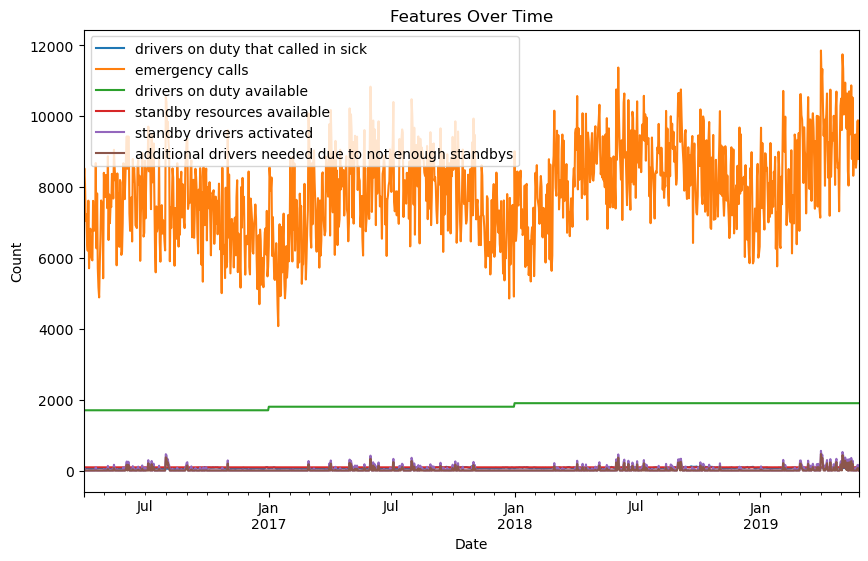

In [84]:
# Plot all variables over time
plt.figure(figsize=(10, 6))
for label in df.columns:
    df[label].plot()
    plt.title('Features Over Time')
    plt.ylabel('Count')
    plt.legend()

In [85]:
df.head()

,drivers on duty that called in sick,emergency calls,drivers on duty available,standby resources available,standby drivers activated,additional drivers needed due to not enough standbys
Date,,,,,,
2016-04-01,73,8154.0,1700,90,4.0,0.0
2016-04-02,64,8526.0,1700,90,70.0,0.0
2016-04-03,68,8088.0,1700,90,0.0,0.0
2016-04-04,71,7044.0,1700,90,0.0,0.0
2016-04-05,63,7236.0,1700,90,0.0,0.0


The fact that, regardless of the number of on-duty drivers calling in sick, the number of on-duty drivers available is almost always constant raises concern about the quality and veracity of the data. However, we will assume that when x on-duty drivers call in sick, x standby drivers are put on duty to replace those that called in sick and x non-standby drivers are put on standby to replace those that are now on duty.

In [86]:
# Create a new column called "month"
df['month'] = df.index.month

# Create a new column 'day' with the day of the month from the index
df['day of month'] = df.index.day

# Create a new column 'day of week' with the day of the week from the index (Monday is 0, Tuesday is 1, etc)
df['day of week'] = df.index.dayofweek

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 9 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   drivers on duty that called in sick                   1152 non-null   int64  
 1   emergency calls                                       1152 non-null   float64
 2   drivers on duty available                             1152 non-null   int64  
 3   standby resources available                           1152 non-null   int64  
 4   standby drivers activated                             1152 non-null   float64
 5   additional drivers needed due to not enough standbys  1152 non-null   float64
 6   month                                                 1152 non-null   int64  
 7   day of month                                          1152 non-null   int64  
 8   day of week                              

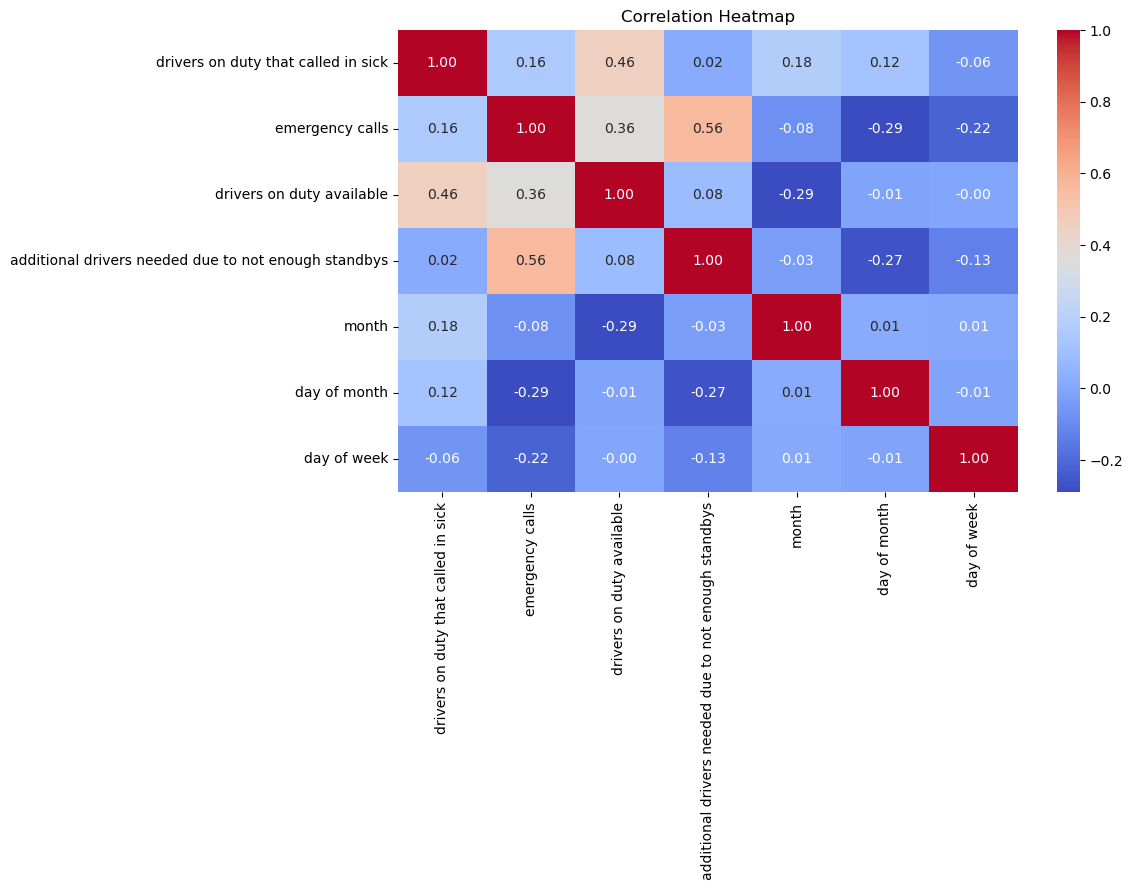

In [87]:
# Calculate correlation matrix
correlation_matrix = df.drop(columns=['standby resources available','standby drivers activated']).corr()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is a moderetely strong correlation between additional drivers needed due to not enough standby drivers
and emergency calls. This is so because, considering that standby resources available is always 90, the higher the number of calls, the higher the number of additional standby drivers are needed.

After the threshold of calls that the on-duty and standby drivers can bear is reached, These two variables are expected to be directly proportional. Nevertheless, we want to predict the number of standby drivers activated so that we can set the predicted number of drivers on standby and ideally keep the additional drivers required to zero.

In addition, this variable (additional drivers needed due to not enough standby drivers) only exists because the number of standby drivers available is always 90. If we set the number of standby drivers available based on the prediction for activated standby drivers, then we will be able to keep additional drivers to zero (or close to zero).

Thus, additional standby drivers is not a variable that we should use in the modeling process. Therefore, we should drop it.

Based on the understanding we have of the data, we expect that the number of additional drivers needed due to not enough standbys + the number of standby resources available to be equal to the number of standbys activated, when the number of standbys activated is equal to or greater than 90. When the number of standby activated is less than 90 (or the number of standby resources available), the number of additional drivers needed due to not enough standby drivers is expected to be zero.

If these assuptions/expectations are true, we will drop the number of additional drivers needed due to not enough standbys and the number of standby resources available because apart from being a strongly correlated variable and a constant, respectively, their value/number is already embedded in the target variable.  

In [88]:
df[['standby drivers activated','additional drivers needed due to not enough standbys','standby resources available']].head()

,standby drivers activated,additional drivers needed due to not enough standbys,standby resources available
Date,,,
2016-04-01,4.0,0.0,90
2016-04-02,70.0,0.0,90
2016-04-03,0.0,0.0,90
2016-04-04,0.0,0.0,90
2016-04-05,0.0,0.0,90


In [89]:
# Filter rows where 'number_of_standbys_activated' is greater than 90
filtered_df = df[df['standby drivers activated'] >= 90]
filtered_df['sum of additional and available standby drivers'] = filtered_df['additional drivers needed due to not enough standbys'] + filtered_df['standby resources available']

# Display only selected columns for the filtered DataFrame
result = filtered_df[['sum of additional and available standby drivers',
                      'standby drivers activated',
                      'additional drivers needed due to not enough standbys',
                      'standby resources available']]
result.head()

,sum of additional and available standby drivers,standby drivers activated,additional drivers needed due to not enough standbys,standby resources available
Date,,,,
2016-04-19,93.0,93.0,3.0,90
2016-05-07,131.0,131.0,41.0,90
2016-05-16,162.0,162.0,72.0,90
2016-05-30,93.0,93.0,3.0,90
2016-06-03,154.0,154.0,64.0,90


The expectations/assumptions hold true. Thus, the two columns mentioned above shall be dropped from the dataset.

In [90]:
# Drop additional drivers needed due to not enough standbys and standby resources available
df = df.drop(columns=['additional drivers needed due to not enough standbys','standby resources available'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   drivers on duty that called in sick  1152 non-null   int64  
 1   emergency calls                      1152 non-null   float64
 2   drivers on duty available            1152 non-null   int64  
 3   standby drivers activated            1152 non-null   float64
 4   month                                1152 non-null   int64  
 5   day of month                         1152 non-null   int64  
 6   day of week                          1152 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 72.0 KB


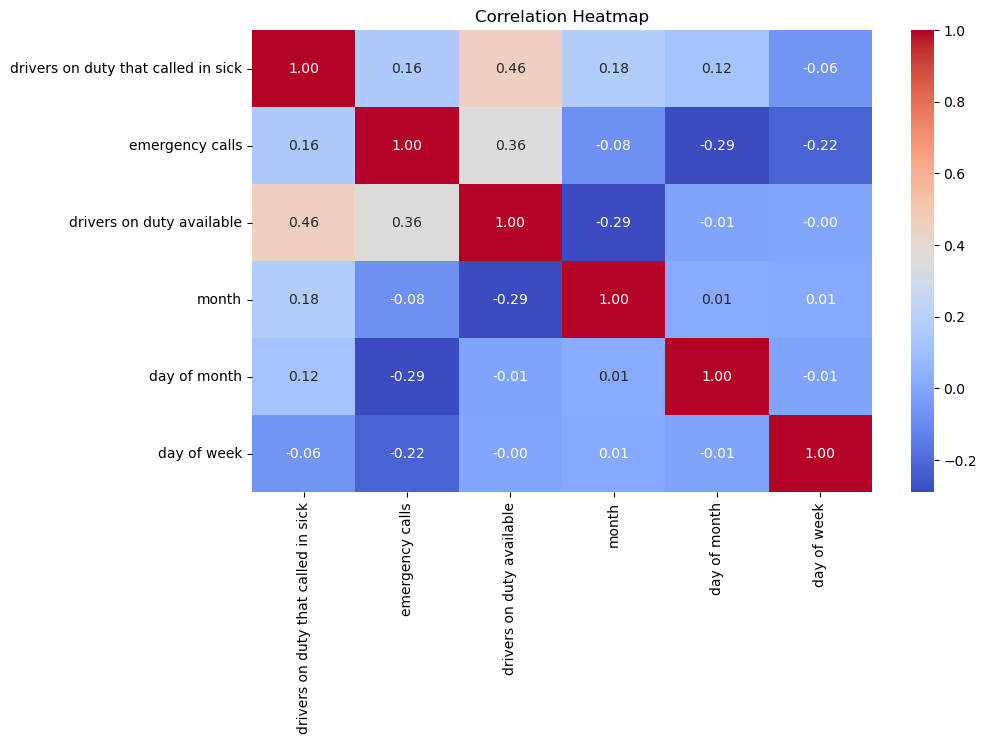

In [91]:
# Calculate correlation matrix
correlation_matrix2 = df.drop(columns=['standby drivers activated']).corr()   

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# MODEL BUILDING

# Building the main model

We are interested in predicting the number of standby drivers activated. 
As demonstrated, there are temporal patterns in the data and there are independent features that do have some impact on the target feature.
We will use time series models to predict the number of on-duty drivers that called in sick and the number of on-duty drivers that are available.
The output from these models and the intended month, day of the week, and day of the month shall be fed into a regression model that will predict the number of standby drivers activated.

In [92]:
# Split the data into features and target variable
X = df.drop(["standby drivers activated"], axis=1)
y = df['standby drivers activated']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# Baseline model: Use mean of training labels as prediction
baseline_prediction = np.mean(y_train)

# Evaluate baseline model
baseline_predictions = np.full_like(y_test, baseline_prediction)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_r2 = r2_score(y_test, baseline_predictions)

print("Baseline Mean Squared Error:", baseline_mse)
print("Baseline R^2 Score:", baseline_r2)

Baseline Mean Squared Error: 3948.0596391092417
Baseline R^2 Score: -0.04265361361883846


In [94]:
# Train a linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Mean Squared Error:", mse_lr)
print("Linear Regression R^2 Score:", r2_lr)


Linear Regression Mean Squared Error: 2524.2737605261527
Linear Regression R^2 Score: 0.33335780136046145


In [95]:
# Instantiate the decision tree regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Train the decision tree model
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the decision tree model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Mean Squared Error:", mse_dt)
print("Decision Tree R^2 Score:", r2_dt)

Decision Tree Mean Squared Error: 32.59307359307359
Decision Tree R^2 Score: 0.9913924081530768


In [96]:
# Instantiate the Random Forest regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
random_forest.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R^2 Score:", r2_rf)

Random Forest Mean Squared Error: 32.90772510822511
Random Forest R^2 Score: 0.9913093109941451


In [97]:
# Instantiate the SVR model
svr = SVR(kernel='rbf')  # You can specify different kernels like 'linear', 'poly', 'rbf', etc.

# Train the SVR model
svr.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr.predict(X_test)

# Evaluate the SVR model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR Mean Squared Error:", mse_svr)
print("SVR R^2 Score:", r2_svr)

SVR Mean Squared Error: 3894.1987192886922
SVR R^2 Score: -0.02842933946466175


In [98]:
# Instantiate the Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can adjust the regularization strength by changing alpha

# Train the Ridge Regression model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the Ridge Regression model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Mean Squared Error:", mse_ridge)
print("Ridge Regression R^2 Score:", r2_ridge)

Ridge Regression Mean Squared Error: 2524.2740713712647
Ridge Regression R^2 Score: 0.33335771926854585


In [99]:
# Instantiate the Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the regularization strength by changing alpha

# Train the Lasso Regression model
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the Lasso Regression model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Mean Squared Error:", mse_lasso)
print("Lasso Regression R^2 Score:", r2_lasso)

Lasso Regression Mean Squared Error: 2525.815583388028
Lasso Regression R^2 Score: 0.33295061724333985


In [100]:
# Instantiate the MultiLayerPerceptronRegressor model
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', random_state=42)

# Train the MLPRegressor model
mlp_model.fit(X_train, y_train)

# Make predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluate the MLPRegressor model
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regression Mean Squared Error:", mse_mlp)
print("MLP Regression R^2 Score:", r2_mlp)

MLP Regression Mean Squared Error: 124.11091074358653
MLP Regression R^2 Score: 0.9672232181362078


In [101]:
model_evaluation = pd.DataFrame({"mse":[baseline_mse, mse_lr, mse_dt, mse_rf, mse_svr, mse_ridge, mse_lasso, mse_mlp],
                                 "r2":[baseline_r2, r2_lr, r2_dt, r2_rf, r2_svr, r2_ridge, r2_lasso, r2_mlp],
                                 "label":["Baseline", "Linear Regression", "Decision Tree", "Random Forest",
                                          "SVR", "Ridge Regression", "Lasso Regression", "MLP Regression"]})

In [102]:
model_evaluation.head(20)

,mse,r2,label
0,3948.059639,-0.042654,Baseline
1,2524.273761,0.333358,Linear Regression
2,32.593074,0.991392,Decision Tree
3,32.907725,0.991309,Random Forest
4,3894.198719,-0.028429,SVR
5,2524.274071,0.333358,Ridge Regression
6,2525.815583,0.332951,Lasso Regression
7,124.110911,0.967223,MLP Regression


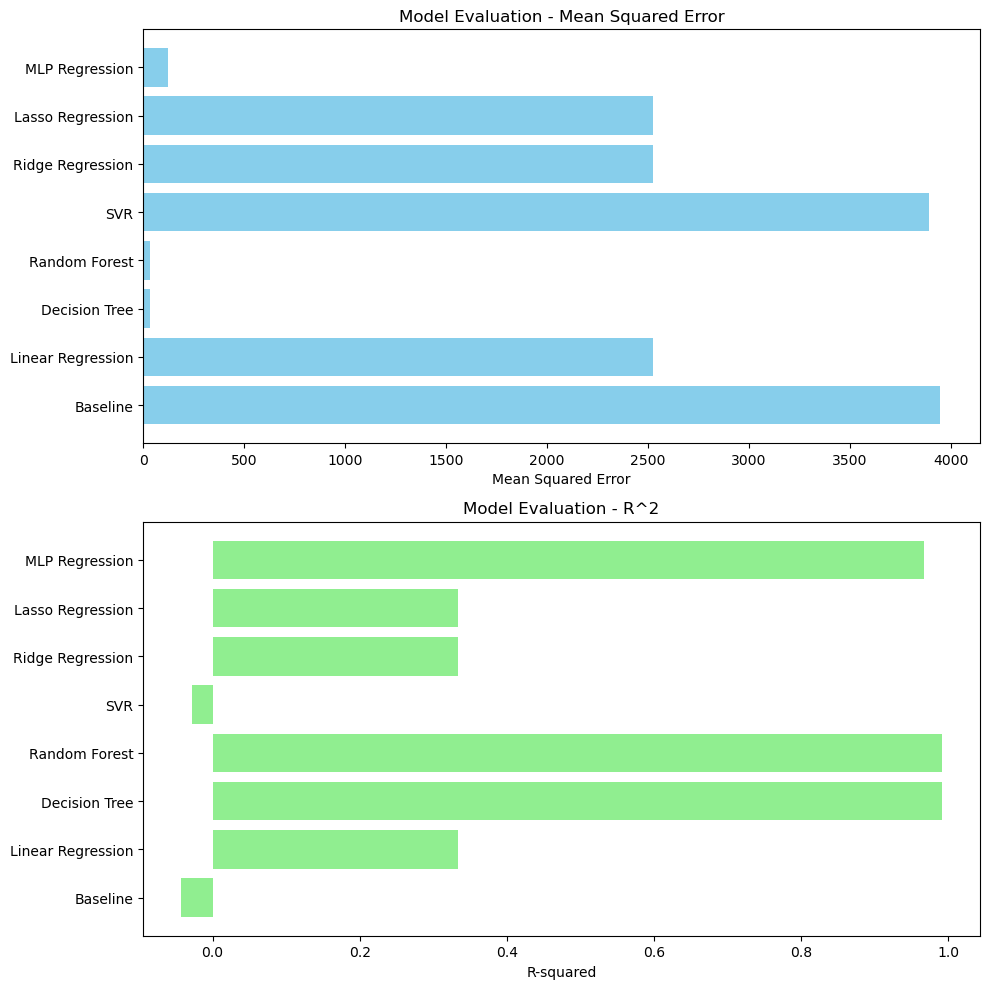

In [103]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# MSE plot
ax1.barh(model_evaluation['label'], model_evaluation['mse'], color='skyblue')
ax1.set_xlabel('Mean Squared Error')
ax1.set_title('Model Evaluation - Mean Squared Error')

# R^2 plot
ax2.barh(model_evaluation['label'], model_evaluation['r2'], color='lightgreen')
ax2.set_xlabel('R-squared')
ax2.set_title('Model Evaluation - R^2')

plt.tight_layout()
plt.show()

Based on the results, Randon Forest is the best performing model. Therefore, we will Random Forest to predict the number of standby drivers activated.

# Predicting Emergency Calls

In [105]:
# Create a dataframe to store emergency calls data
df_calls = pd.DataFrame()
df_calls['emergency calls'] = df['emergency calls']
df_calls.head()

,emergency calls
Date,
2016-04-01,8154.0
2016-04-02,8526.0
2016-04-03,8088.0
2016-04-04,7044.0
2016-04-05,7236.0


RMSE: 254.59663198738528


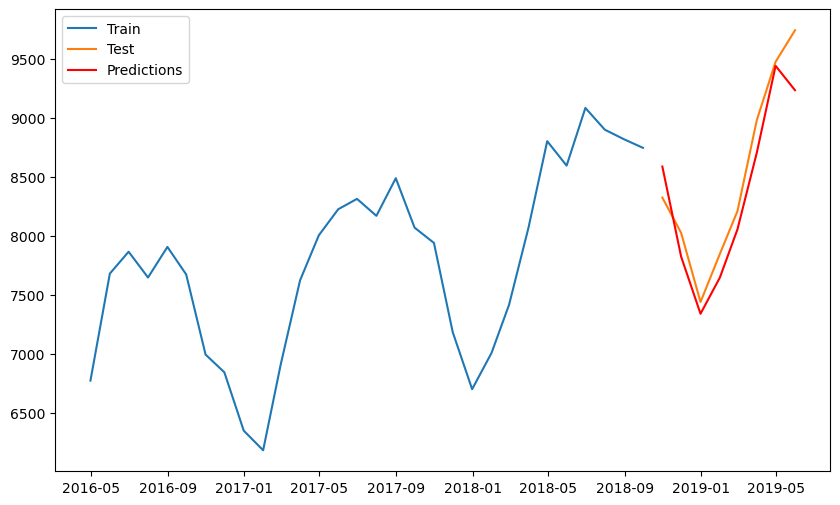

Future forecast: 2018-10-31    8589.855737
2018-11-30    7826.914237
2018-12-31    7342.432273
2019-01-31    7649.996874
2019-02-28    8057.104412
2019-03-31    8708.189330
2019-04-30    9443.257825
2019-05-31    9236.528630
2019-06-30    9726.206897
2019-07-31    9541.641249
2019-08-31    9459.179647
2019-09-30    9387.941398
Freq: M, Name: predicted_mean, dtype: float64


In [110]:
# Resample data from daily to monthly
df_calls = df_calls.resample('M').mean()

# Split data into train and test sets
train_size = int(len(df_calls) * 0.8)
train, test = df_calls.iloc[:train_size], df_calls.iloc[train_size:]

# Define and fit SARIMA model
order = (1, 1, 1)  # (p, d, q) parameters for non-seasonal components
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S) parameters for seasonal components
model_call = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model_call.fit()

# Make predictions
predictions_call = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model
mse = mean_squared_error(test, predictions_call)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions_call, label='Predictions', color='red')
plt.legend()
plt.show()

# Forecast future emergency calls
forecast_steps = 12  # Example: forecast for 12 steps (months)
future_forecast = model_fit.forecast(steps=forecast_steps)
print('Future forecast:', future_forecast)

Text(0.5, 1.0, 'Emergency Calls - Future Predictions')

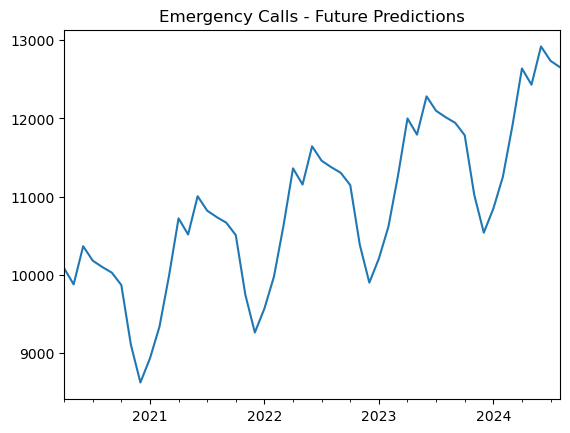

In [111]:
# Make predictions
predictions_call = model_fit.predict(start=48, end=100, dynamic=False)
predictions_call.plot()
plt.title('Emergency Calls - Future Predictions')

# Data & Fuction Preparation For Predicting Sick and Available On-duty Drivers

In [40]:
# Creating a dataframe to store the data needed in the next time series models
df_on_duty_drivers = pd.DataFrame()
df_on_duty_drivers['drivers on duty that called in sick'] = df['drivers on duty that called in sick']
df_on_duty_drivers['drivers on duty available'] = df['drivers on duty available']

In [41]:
# Creating new columns based on date
df_on_duty_drivers['Seconds'] = df_on_duty_drivers.index.map(pd.Timestamp.timestamp)

day = 60*60*24
year = 365.2425*day

df_on_duty_drivers['Day sin'] = np.sin(df_on_duty_drivers['Seconds'] * (2* np.pi / day))
df_on_duty_drivers['Day cos'] = np.cos(df_on_duty_drivers['Seconds'] * (2 * np.pi / day))
df_on_duty_drivers['Year sin'] = np.sin(df_on_duty_drivers['Seconds'] * (2 * np.pi / year))
df_on_duty_drivers['Year cos'] = np.cos(df_on_duty_drivers['Seconds'] * (2 * np.pi / year))

# Creating two new dataframes
df_sick_drivers = df_on_duty_drivers.drop(['Seconds',
                              'drivers on duty available'], axis=1)

df_drivers_available = df_on_duty_drivers.drop(['Seconds',
                                   'drivers on duty that called in sick'], axis=1)

In [112]:
df_on_duty_drivers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   drivers on duty that called in sick  1152 non-null   int64  
 1   drivers on duty available            1152 non-null   int64  
 2   Seconds                              1152 non-null   float64
 3   Day sin                              1152 non-null   float64
 4   Day cos                              1152 non-null   float64
 5   Year sin                             1152 non-null   float64
 6   Year cos                             1152 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 72.0 KB


In [42]:
# Defining a funtion to extract X and y from df

def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0]]
    y.append(label)
  return np.array(X), np.array(y)

In [43]:
# Defining a funtion to plot results

def plot_predictions(model, X, y, start=0, end=100,):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y.flatten()})
  mse_value =  mean_squared_error(predictions, y)
  plt.plot(df['Predictions'][start:end], label='Prediction')
  plt.plot(df['Actuals'][start:end], label='Actual')
  plt.title('Sick Drivers')
  plt.legend()
  return df, mse_value

In [44]:
# Defining a funtion to plot results

def plot_predictions2(model, X, y, start=0, end=100,):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y.flatten()})
  mse_value =  mean_squared_error(predictions, y)
  plt.plot(df['Predictions'][start:end], label='Prediction')
  plt.plot(df['Actuals'][start:end], label='Actual')
  plt.title('Available Drivers')
  plt.legend()
  return df, mse_value

# Predicting the Number of On-duty Sick Drivers

In [51]:
WINDOW_SIZE = 7
X1, y1 = df_to_X_y(df_sick_drivers, WINDOW_SIZE)
X1.shape, y1.shape

((1145, 7, 5), (1145, 1))

In [52]:
X_train1, y_train1 = X1[:916], y1[:916]
X_val1, y_val1 = X1[916:1031], y1[916:1031]
X_test1, y_test1 = X1[1031:], y1[1031:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((916, 7, 5), (916, 1), (115, 7, 5), (115, 1), (114, 7, 5), (114, 1))

In [53]:
model_sick = Sequential()
model_sick.add(InputLayer((7, 5)))
model_sick.add(Conv1D(32, kernel_size=2))
model_sick.add(Flatten())
model_sick.add(Dense(8, 'relu'))
model_sick.add(Dense(1, 'linear'))

model_sick.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 32)             352       
                                                                 
 flatten_1 (Flatten)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1544      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1905 (7.44 KB)
Trainable params: 1905 (7.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
cp = ModelCheckpoint('model_sick/', save_best_only=True)
model_sick.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [55]:
model_sick.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, callbacks=[cp])

Epoch 1/30
17/29 [================>.............] - ETA: 0s - loss: 2525.9783 - root_mean_squared_error: 50.2591 INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 43ms/step - loss: 1617.8447 - root_mean_squared_error: 40.2224 - val_loss: 110.4971 - val_root_mean_squared_error: 10.5118
Epoch 2/30
16/29 [===============>..............] - ETA: 0s - loss: 132.1471 - root_mean_squared_error: 11.4955INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 43ms/step - loss: 116.1003 - root_mean_squared_error: 10.7750 - val_loss: 98.6176 - val_root_mean_squared_error: 9.9306
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 80.1068 - root_mean_squared_error: 8.9502INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 66ms/step - loss: 80.1068 - root_mean_squared_error: 8.9502 - val_loss: 97.4525 - val_root_mean_squared_error: 9.8718
Epoch 4/30
24/29 [=======================>......] - ETA: 0s - loss: 76.4036 - root_mean_squared_error: 8.7409INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 56ms/step - loss: 76.0215 - root_mean_squared_error: 8.7190 - val_loss: 94.7293 - val_root_mean_squared_error: 9.7329
Epoch 5/30
15/29 [==============>...............] - ETA: 0s - loss: 74.4645 - root_mean_squared_error: 8.6293INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 49ms/step - loss: 75.3404 - root_mean_squared_error: 8.6799 - val_loss: 93.9926 - val_root_mean_squared_error: 9.6950
Epoch 6/30
17/29 [================>.............] - ETA: 0s - loss: 72.8715 - root_mean_squared_error: 8.5365INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 36ms/step - loss: 74.3808 - root_mean_squared_error: 8.6244 - val_loss: 92.7829 - val_root_mean_squared_error: 9.6324
Epoch 7/30
26/29 [=========================>....] - ETA: 0s - loss: 74.8183 - root_mean_squared_error: 8.6498INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 47ms/step - loss: 72.7753 - root_mean_squared_error: 8.5308 - val_loss: 91.7501 - val_root_mean_squared_error: 9.5786
Epoch 8/30
28/29 [===========================>..] - ETA: 0s - loss: 72.9429 - root_mean_squared_error: 8.5407INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 38ms/step - loss: 72.4379 - root_mean_squared_error: 8.5110 - val_loss: 90.3957 - val_root_mean_squared_error: 9.5077
Epoch 9/30
16/29 [===============>..............] - ETA: 0s - loss: 68.4861 - root_mean_squared_error: 8.2756INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 48ms/step - loss: 70.4949 - root_mean_squared_error: 8.3961 - val_loss: 90.0229 - val_root_mean_squared_error: 9.4880
Epoch 10/30
24/29 [=======================>......] - ETA: 0s - loss: 73.4414 - root_mean_squared_error: 8.5698INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 47ms/step - loss: 69.6721 - root_mean_squared_error: 8.3470 - val_loss: 87.3001 - val_root_mean_squared_error: 9.3435
Epoch 11/30
18/29 [=================>............] - ETA: 0s - loss: 66.8699 - root_mean_squared_error: 8.1774  INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 38ms/step - loss: 68.0909 - root_mean_squared_error: 8.2517 - val_loss: 85.9610 - val_root_mean_squared_error: 9.2715
Epoch 12/30
28/29 [===========================>..] - ETA: 0s - loss: 67.7025 - root_mean_squared_error: 8.2282INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 50ms/step - loss: 66.9588 - root_mean_squared_error: 8.1828 - val_loss: 84.8202 - val_root_mean_squared_error: 9.2098
Epoch 13/30
15/29 [==============>...............] - ETA: 0s - loss: 73.4480 - root_mean_squared_error: 8.5702INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 41ms/step - loss: 65.8485 - root_mean_squared_error: 8.1147 - val_loss: 83.5577 - val_root_mean_squared_error: 9.1410
Epoch 14/30
28/29 [===========================>..] - ETA: 0s - loss: 65.7976 - root_mean_squared_error: 8.1116INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 49ms/step - loss: 65.0592 - root_mean_squared_error: 8.0659 - val_loss: 82.0562 - val_root_mean_squared_error: 9.0585
Epoch 15/30
20/29 [===================>..........] - ETA: 0s - loss: 59.6490 - root_mean_squared_error: 7.7233INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 58ms/step - loss: 63.5248 - root_mean_squared_error: 7.9702 - val_loss: 80.8727 - val_root_mean_squared_error: 8.9929
Epoch 16/30
29/29 [==============================] - ETA: 0s - loss: 62.3987 - root_mean_squared_error: 7.8993INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 55ms/step - loss: 62.3987 - root_mean_squared_error: 7.8993 - val_loss: 80.0178 - val_root_mean_squared_error: 8.9453
Epoch 17/30
27/29 [==========================>...] - ETA: 0s - loss: 61.9411 - root_mean_squared_error: 7.8703INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 41ms/step - loss: 60.9538 - root_mean_squared_error: 7.8073 - val_loss: 79.8470 - val_root_mean_squared_error: 8.9357
Epoch 18/30
18/29 [=================>............] - ETA: 0s - loss: 59.1925 - root_mean_squared_error: 7.6937  INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 39ms/step - loss: 59.9170 - root_mean_squared_error: 7.7406 - val_loss: 77.0443 - val_root_mean_squared_error: 8.7775
Epoch 19/30
19/29 [==================>...........] - ETA: 0s - loss: 57.5703 - root_mean_squared_error: 7.5875INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 52ms/step - loss: 58.5227 - root_mean_squared_error: 7.6500 - val_loss: 76.3842 - val_root_mean_squared_error: 8.7398
Epoch 20/30
16/29 [===============>..............] - ETA: 0s - loss: 60.5153 - root_mean_squared_error: 7.7792INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 42ms/step - loss: 58.9651 - root_mean_squared_error: 7.6789 - val_loss: 74.5147 - val_root_mean_squared_error: 8.6322
Epoch 21/30
22/29 [=====================>........] - ETA: 0s - loss: 54.3156 - root_mean_squared_error: 7.3699INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 2s 60ms/step - loss: 56.2392 - root_mean_squared_error: 7.4993 - val_loss: 73.4907 - val_root_mean_squared_error: 8.5727
Epoch 22/30
29/29 [==============================] - 0s 5ms/step - loss: 55.3341 - root_mean_squared_error: 7.4387 - val_loss: 74.2637 - val_root_mean_squared_error: 8.6176
Epoch 23/30
16/29 [===============>..............] - ETA: 0s - loss: 57.0667 - root_mean_squared_error: 7.5543INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 37ms/step - loss: 54.6922 - root_mean_squared_error: 7.3954 - val_loss: 71.6892 - val_root_mean_squared_error: 8.4669
Epoch 24/30
23/29 [======================>.......] - ETA: 0s - loss: 52.1431 - root_mean_squared_error: 7.2210INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 47ms/step - loss: 53.5785 - root_mean_squared_error: 7.3197 - val_loss: 70.8553 - val_root_mean_squared_error: 8.4176
Epoch 25/30
15/29 [==============>...............] - ETA: 0s - loss: 47.0444 - root_mean_squared_error: 6.8589INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 37ms/step - loss: 52.8886 - root_mean_squared_error: 7.2725 - val_loss: 69.6308 - val_root_mean_squared_error: 8.3445
Epoch 26/30
16/29 [===============>..............] - ETA: 0s - loss: 51.3801 - root_mean_squared_error: 7.1680INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 43ms/step - loss: 52.2496 - root_mean_squared_error: 7.2284 - val_loss: 68.7761 - val_root_mean_squared_error: 8.2931
Epoch 27/30
17/29 [================>.............] - ETA: 0s - loss: 52.7870 - root_mean_squared_error: 7.2655INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 47ms/step - loss: 50.5404 - root_mean_squared_error: 7.1092 - val_loss: 67.8183 - val_root_mean_squared_error: 8.2352
Epoch 28/30
26/29 [=========================>....] - ETA: 0s - loss: 49.6971 - root_mean_squared_error: 7.0496INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 43ms/step - loss: 49.9241 - root_mean_squared_error: 7.0657 - val_loss: 67.1927 - val_root_mean_squared_error: 8.1971
Epoch 29/30
15/29 [==============>...............] - ETA: 0s - loss: 47.3801 - root_mean_squared_error: 6.8833INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 53ms/step - loss: 49.1685 - root_mean_squared_error: 7.0120 - val_loss: 66.0674 - val_root_mean_squared_error: 8.1282
Epoch 30/30
29/29 [==============================] - ETA: 0s - loss: 48.7120 - root_mean_squared_error: 6.9794INFO:tensorflow:Assets written to: model_sick\assets


INFO:tensorflow:Assets written to: model_sick\assets


29/29 [==============================] - 1s 51ms/step - loss: 48.7120 - root_mean_squared_error: 6.9794 - val_loss: 65.3560 - val_root_mean_squared_error: 8.0843


4/4 [==============================] - 0s 4ms/step


(     Predictions  Actuals
 0      67.739540     51.0
 1      60.504921     58.0
 2      57.702534     49.0
 3      55.132290     57.0
 4      57.467052     61.0
 ..           ...      ...
 109    74.915329     86.0
 110    79.257820     81.0
 111    78.697647     76.0
 112    78.938499     83.0
 113    79.733482     77.0
 
 [114 rows x 2 columns],
 45.35334020504971)

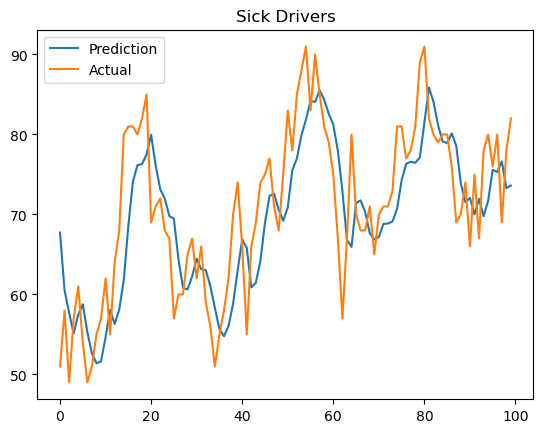

In [56]:
plot_predictions(model_sick, X_test1, y_test1)

# Predicting On-duty Drivers Available

In [57]:
WINDOW_SIZE = 7
X2, y2 = df_to_X_y(df_drivers_available, WINDOW_SIZE)
X2.shape, y2.shape

((1145, 7, 5), (1145, 1))

In [58]:
X_train2, y_train2 = X2[:916], y2[:916]
X_val2, y_val2 = X2[916:1031], y2[916:1031]
X_test2, y_test2 = X2[1031:], y2[1031:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((916, 7, 5), (916, 1), (115, 7, 5), (115, 1), (114, 7, 5), (114, 1))

In [59]:
model_available = Sequential([
    InputLayer((7, 5)),
    Conv1D(32, kernel_size=2),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

model_available.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 6, 32)             352       
                                                                 
 flatten_2 (Flatten)         (None, 192)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1544      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1905 (7.44 KB)
Trainable params: 1905 (7.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
# Setting up model checkpoint to save the best model during training
# `save_best_only=True` ensures only the best model based on validation loss will be saved
cp = ModelCheckpoint('model_available/', save_best_only=True)

# Compiling the model
from tensorflow.keras.optimizers import Adamax



model_available.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
#model2.compile(loss=MeanSquaredError(), optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999), metrics=[RootMeanSquaredError()])

In [61]:
model_available.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=30, callbacks=[cp])

Epoch 1/30
17/29 [================>.............] - ETA: 0s - loss: 5039866.0000 - root_mean_squared_error: 2244.9646 INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 2s 47ms/step - loss: 4493739.0000 - root_mean_squared_error: 2119.8440 - val_loss: 3535281.2500 - val_root_mean_squared_error: 1880.2344
Epoch 2/30
17/29 [================>.............] - ETA: 0s - loss: 2684665.7500 - root_mean_squared_error: 1638.4950INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 45ms/step - loss: 2356640.5000 - root_mean_squared_error: 1535.1354 - val_loss: 1760252.6250 - val_root_mean_squared_error: 1326.7451
Epoch 3/30
15/29 [==============>...............] - ETA: 0s - loss: 1323003.7500 - root_mean_squared_error: 1150.2190INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 38ms/step - loss: 1111333.3750 - root_mean_squared_error: 1054.1980 - val_loss: 764153.0625 - val_root_mean_squared_error: 874.1585
Epoch 4/30
15/29 [==============>...............] - ETA: 0s - loss: 555246.1875 - root_mean_squared_error: 745.1484INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 37ms/step - loss: 451714.7812 - root_mean_squared_error: 672.0973 - val_loss: 278705.3125 - val_root_mean_squared_error: 527.9255
Epoch 5/30
24/29 [=======================>......] - ETA: 0s - loss: 172575.3125 - root_mean_squared_error: 415.4218INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 2s 56ms/step - loss: 162842.4844 - root_mean_squared_error: 403.5375 - val_loss: 115515.0625 - val_root_mean_squared_error: 339.8751
Epoch 6/30
25/29 [========================>.....] - ETA: 0s - loss: 80016.5547 - root_mean_squared_error: 282.8720INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 51ms/step - loss: 76838.4766 - root_mean_squared_error: 277.1975 - val_loss: 56626.1484 - val_root_mean_squared_error: 237.9625
Epoch 7/30
25/29 [========================>.....] - ETA: 0s - loss: 37926.6250 - root_mean_squared_error: 194.7476INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 2s 57ms/step - loss: 36323.1484 - root_mean_squared_error: 190.5863 - val_loss: 25195.1465 - val_root_mean_squared_error: 158.7298
Epoch 8/30
17/29 [================>.............] - ETA: 0s - loss: 18353.3496 - root_mean_squared_error: 135.4745INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 2s 59ms/step - loss: 15645.5752 - root_mean_squared_error: 125.0823 - val_loss: 10151.6328 - val_root_mean_squared_error: 100.7553
Epoch 9/30
13/29 [============>.................] - ETA: 0s - loss: 7849.5107 - root_mean_squared_error: 88.5975  INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 51ms/step - loss: 6152.2822 - root_mean_squared_error: 78.4365 - val_loss: 3695.6807 - val_root_mean_squared_error: 60.7921
Epoch 10/30
15/29 [==============>...............] - ETA: 0s - loss: 2714.3716 - root_mean_squared_error: 52.0996INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 42ms/step - loss: 2226.2869 - root_mean_squared_error: 47.1835 - val_loss: 1209.8188 - val_root_mean_squared_error: 34.7825
Epoch 11/30
21/29 [====================>.........] - ETA: 0s - loss: 844.0601 - root_mean_squared_error: 29.0527 INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 49ms/step - loss: 763.2779 - root_mean_squared_error: 27.6275 - val_loss: 350.7330 - val_root_mean_squared_error: 18.7279
Epoch 12/30
16/29 [===============>..............] - ETA: 0s - loss: 338.0111 - root_mean_squared_error: 18.3851INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 44ms/step - loss: 269.9460 - root_mean_squared_error: 16.4300 - val_loss: 86.9834 - val_root_mean_squared_error: 9.3265
Epoch 13/30
23/29 [======================>.......] - ETA: 0s - loss: 134.3125 - root_mean_squared_error: 11.5893INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 40ms/step - loss: 118.8436 - root_mean_squared_error: 10.9015 - val_loss: 17.2838 - val_root_mean_squared_error: 4.1574
Epoch 14/30
29/29 [==============================] - ETA: 0s - loss: 77.1183 - root_mean_squared_error: 8.7817INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 42ms/step - loss: 77.1183 - root_mean_squared_error: 8.7817 - val_loss: 2.1467 - val_root_mean_squared_error: 1.4652
Epoch 15/30
28/29 [===========================>..] - ETA: 0s - loss: 68.4951 - root_mean_squared_error: 8.2762INFO:tensorflow:Assets written to: model_available\assets


INFO:tensorflow:Assets written to: model_available\assets


29/29 [==============================] - 1s 53ms/step - loss: 67.0009 - root_mean_squared_error: 8.1854 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 16/30
29/29 [==============================] - 0s 5ms/step - loss: 64.4046 - root_mean_squared_error: 8.0252 - val_loss: 0.3097 - val_root_mean_squared_error: 0.5565
Epoch 17/30
29/29 [==============================] - 0s 5ms/step - loss: 63.8949 - root_mean_squared_error: 7.9934 - val_loss: 0.7590 - val_root_mean_squared_error: 0.8712
Epoch 18/30
29/29 [==============================] - 0s 5ms/step - loss: 63.7812 - root_mean_squared_error: 7.9863 - val_loss: 1.0487 - val_root_mean_squared_error: 1.0241
Epoch 19/30
29/29 [==============================] - 0s 5ms/step - loss: 63.7676 - root_mean_squared_error: 7.9855 - val_loss: 1.1714 - val_root_mean_squared_error: 1.0823
Epoch 20/30
29/29 [==============================] - 0s 5ms/step - loss: 63.7260 - root_mean_squared_error: 7.9829 - val_loss: 1.1158 - val_root_mean_s

4/4 [==============================] - 0s 4ms/step


(     Predictions  Actuals
 0    1900.946411   1900.0
 1    1900.942871   1900.0
 2    1900.939087   1900.0
 3    1900.935547   1900.0
 4    1900.931641   1900.0
 ..           ...      ...
 109  1900.746338   1900.0
 110  1900.747192   1900.0
 111  1900.748657   1900.0
 112  1900.750122   1900.0
 113  1900.751709   1900.0
 
 [114 rows x 2 columns],
 0.6411930057301856)

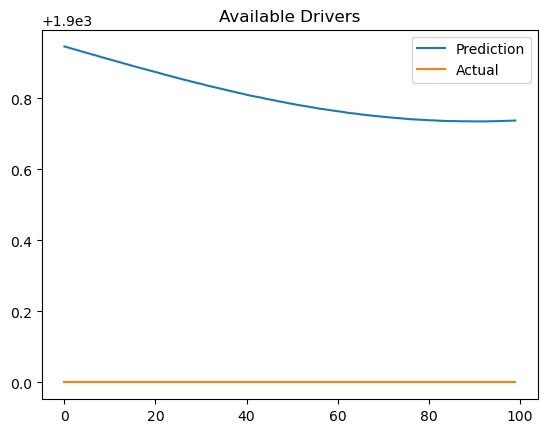

In [62]:
plot_predictions2(model_available, X_test2, y_test2)

4/4 [==============================] - 0s 3ms/step


(     Predictions  Actuals
 0    1901.149414   1900.0
 1    1901.150879   1900.0
 2    1901.151855   1900.0
 3    1901.153198   1900.0
 4    1901.154541   1900.0
 ..           ...      ...
 110  1900.965210   1900.0
 111  1900.961426   1900.0
 112  1900.957764   1900.0
 113  1900.954102   1900.0
 114  1900.950195   1900.0
 
 [115 rows x 2 columns],
 1.2172405000614084)

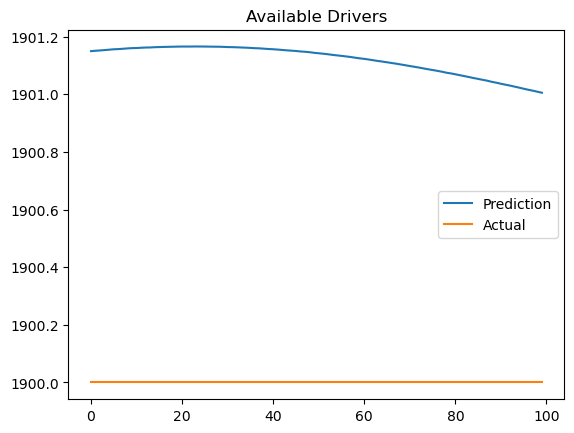

In [64]:
plot_predictions2(model_available, X_val2, y_val2)

29/29 [==============================] - 0s 3ms/step


(     Predictions  Actuals
 0    1700.708740   1700.0
 1    1700.707153   1700.0
 2    1700.705811   1700.0
 3    1700.704102   1700.0
 4    1700.702637   1700.0
 ..           ...      ...
 911  1901.141724   1900.0
 912  1901.143433   1900.0
 913  1901.144775   1900.0
 914  1901.146484   1900.0
 915  1901.147949   1900.0
 
 [916 rows x 2 columns],
 63.48678646919899)

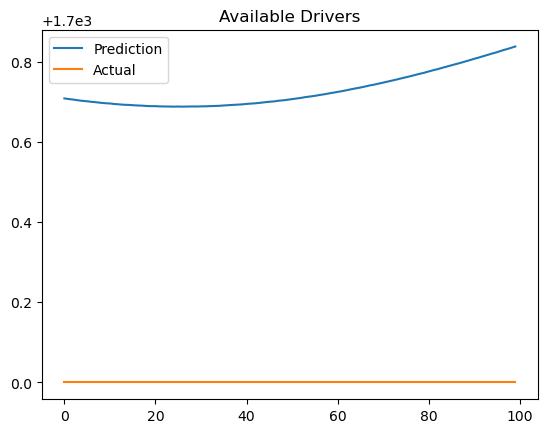

In [65]:
plot_predictions2(model_available, X_train2, y_train2)